In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
overwrite_model=False
restore_model=True
train_model=False

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux"

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax

import numpy as np

from tqdm.auto import tqdm

from functools import partial

from flax import nnx

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import sys 
sys.path.append("examples/sbi-benchmarks")
sys.path.append("src/")
sys.path.append("/lhome/ific/a/aamerio/github/cfm-jax/src")

In [7]:
import sbibm
from utils.sbi_tasks import TwoMoons

from models import FluxParams, Flux, FluxCFMLoss


from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver

from flow_matching.utils import ModelWrapper, GuidedModelWrapper

In [8]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()
observation = twomoons.get_observation(1)

theta = prior.sample((10_000,))
xs = simulator(theta)

In [9]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

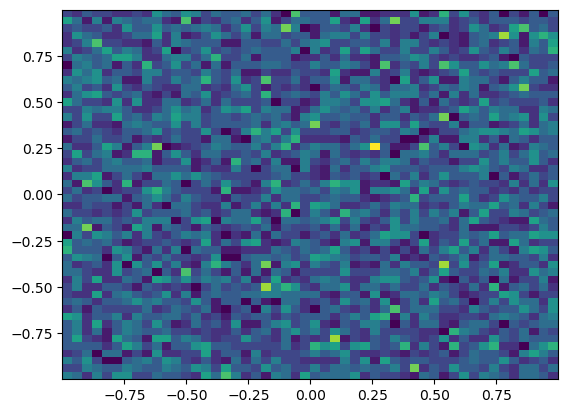

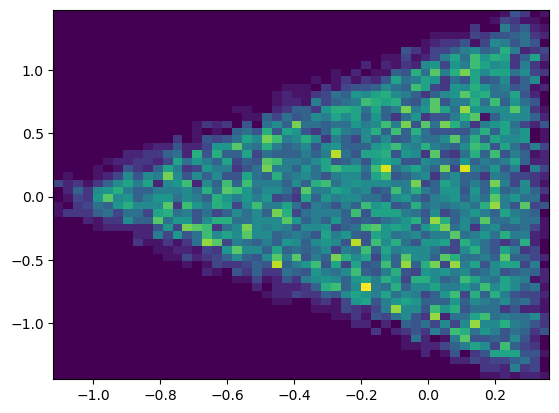

In [10]:
plt.hist2d(theta[:,0],theta[:,1], bins=50, density=True)
plt.show()

plt.hist2d(xs[:,0],xs[:,1], bins=50, density=True)
plt.show()

In [64]:
from sbibm.algorithms import rej_abc  # See help(rej_abc) for keywords
posterior_samples, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=8, num_simulations=100_000)


Running REJ-ABC
INFO:sbibm.algorithms.sbi.mcabc:Running REJ-ABC


Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 2707347.52it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/lhome/ific

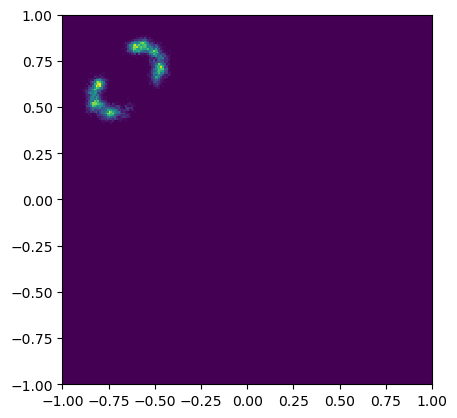

In [65]:
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/tmp/ipykernel_135150/814672839.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(posterior_samples), bins=50, smooth=True, smooth1d=True, range=[(-1, 1), (-1, 1)])


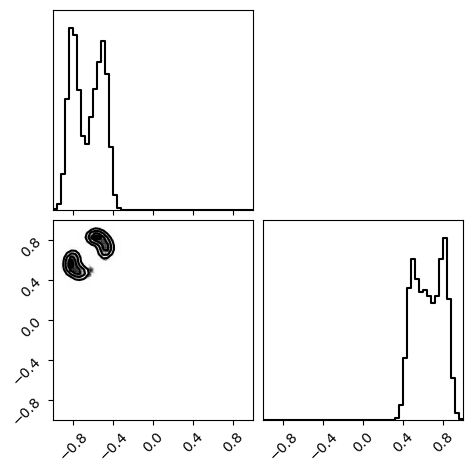

In [66]:
corner(np.array(posterior_samples), bins=50, smooth=True, smooth1d=True, range=[(-1, 1), (-1, 1)])
plt.show(9)

In [13]:
# Once we got samples from an approximate posterior, compare them to the reference:
from sbibm.metrics import c2st
reference_samples = task.get_reference_posterior_samples(num_observation=1)

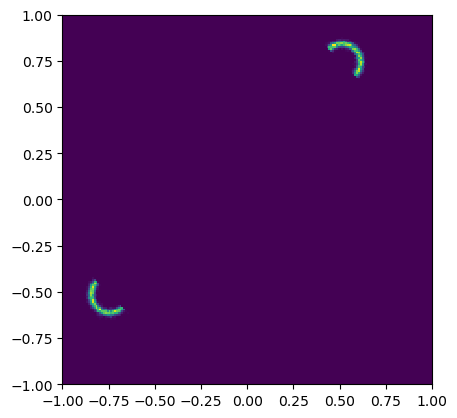

In [14]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [15]:
# c2st_accuracy = c2st(reference_samples, posterior_samples)

In [16]:
# c2st_accuracy # around 0.6

# dataset

In [17]:
# make a dataset
nsamples = int(1e6)
theta = prior.sample((nsamples,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)

val_perc = 0.05

train_size = int(nsamples * (1 - val_perc)) 

train_data = data[:train_size]
val_data = data[train_size:]


In [18]:
# make an infinite dataloader that shuffles the data once it finishes cycling it
class InfiniteDataLoader:
    def __init__(self, data, batch_size, *, rngs: nnx.Rngs):
        self.data = jnp.asarray(data)
        self.batch_size = batch_size
        self.index = 0
        self.rngs = rngs

        self.data_mean = jnp.mean(data, axis=0)
        self.data_std = jnp.std(data, axis=0)

        # self.data = self.normalize(self.data)

    def normalize(self, unnormalized_data):
        # Normalize the data to be between 0 mean and unit varainve
        data = unnormalized_data - self.data_mean
        data = data / self.data_std

        return data

    def unnormalize(self, normdata):
        # Unnormalize the data
        data = normdata * self.data_std
        data = data + self.data_mean
        return data

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self._shuffle()
        batch = self.data[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return batch

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        return self.data[index]

    def _shuffle(self):
        self.data = jax.random.permutation(self.rngs.perm(), self.data)
        self.index = 0

In [19]:
batch_size = 1024 * 4
dataset = InfiniteDataLoader(train_data, batch_size, rngs=nnx.Rngs(0))

# define the CFM model

In [20]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [21]:
params=FluxParams(
            in_channels=1,
            vec_in_dim=None,
            context_in_dim=1,
            hidden_size=40,
            mlp_ratio=3,
            num_heads=4,
            depth=4,
            depth_single_blocks=8,
            axes_dim=[10,],
            theta=10_000,
            qkv_bias=True,
            guidance_embed=False,
            rngs=nnx.Rngs(default=42),
            param_dtype=jnp.bfloat16,
        )

In [22]:
vf_model = Flux(params)

In [23]:
loss_fn_cfm = FluxCFMLoss(path)

In [24]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            2,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux/1/metrics/metrics not found.
ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux/2/metrics/metrics not found.
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Restored model from checkpoint


In [25]:
from numpyro import distributions as dist

p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [26]:
cond_ids = jnp.arange(dim_theta, dtype=jnp.int32).reshape(1,-1,1)
obs_ids = jnp.arange(dim_x, dtype=jnp.int32).reshape(1,-1,1)

def train_loss(vf_model, key: jax.random.PRNGKey):
    batch = next(dataset)
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])

    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

def val_loss(vf_model, key: jax.random.PRNGKey):
    batch = val_data
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])

    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

In [27]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    return loss

In [28]:
rngs = nnx.Rngs(0)

In [29]:
nsteps = 10_000
nepochs = 5


schedule = optax.schedules.linear_schedule(1e-3, 1e-6, nsteps * (nepochs-1), 10000)

opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

opt = optax.MultiSteps(opt, 2)

optimizer = nnx.Optimizer(vf_model, opt)

In [30]:
best_state = nnx.state(vf_model)
val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100
early_stopping = True
# early_stopping = False


# optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4)) 

if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break
            
            key_ = rngs.train_step()
            loss = train_step(vf_model, optimizer, key_)
            l += loss.item()
            if j>0 and j % 100 == 0:
                loss_ = l/100
                val_ = val_loss(vf_model, rngs.val_step())

                ratio = val_ / loss_
                
                if ratio < val_error_ratio:
                    val_loss_value = val_
                    counter = 0
                    best_state = nnx.state(vf_model)
                else:
                    counter += 1
                pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter)
                l=0
        # print(l)



    vf_model.eval()

In [31]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=False,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        2, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

# model wrapper

In [32]:
from einops import rearrange

class FluxWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, conditioned=True, **kwargs), axis=-1)

# sample the posterior

In [33]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx = 8
observation = jnp.array(twomoons.get_observation(idx))
true_param = jnp.array(task.get_true_parameters(idx))
reference_samples = task.get_reference_posterior_samples(num_observation=idx)

# observation = data[0,:2].reshape((1,-1))
# true_param = data[0,2:].reshape((1,-1))

In [34]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1



In [35]:
vf_wrapped = FluxWrapper(vf_model)

In [36]:
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}
res=vf_wrapped(x_init, jnp.array([1.0]), None, **model_extras)

In [37]:
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

sampler_ = solver.get_sampler(time_grid=T, method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model


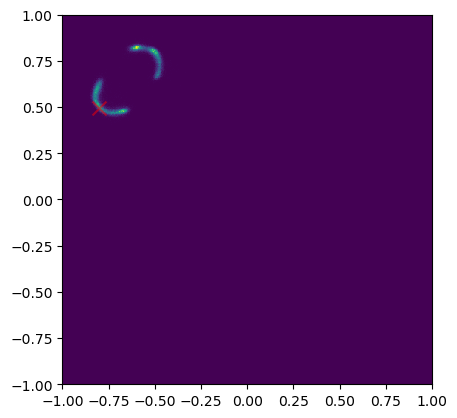

In [38]:
posterior_samples = samples[:,0:2]

plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=(500,500), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

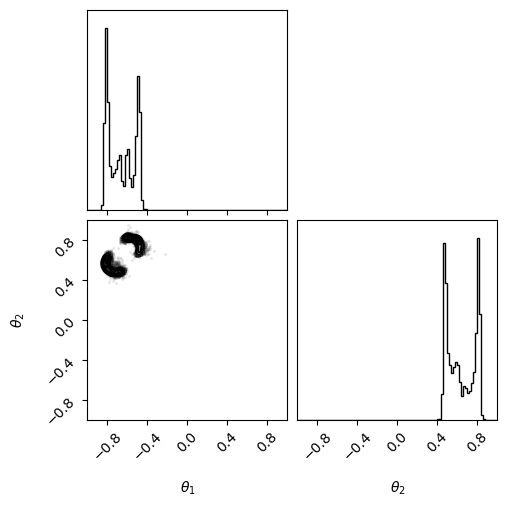

In [39]:
from corner import corner
corner(np.array(posterior_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

/tmp/ipykernel_135150/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


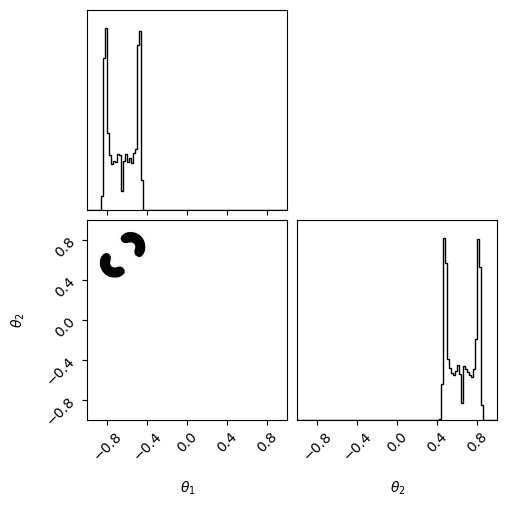

In [40]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# plot analystical posterior

In [41]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [42]:
x_1.shape, cond.shape, cond_ids.shape

((40000, 2), (100000, 2, 1), (1, 2, 1))

In [43]:
vf_wrapped = FluxWrapper(vf_model)
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class

cond = jnp.broadcast_to(observation[...,None], (x_1.shape[0], dim_theta, 1)) # n, dim_theta, 1
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

In [44]:
# # get the logprob
# logp_sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0],method='Dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
# # create an y_init which has theta on the first position and x1,x2 on the second and third position
# y_init = jax.random.normal(key2, (x_1.shape[0], 2))  # n, dim_x

# _ , exact_log_p = logp_sampler(y_init)
# p = jnp.exp(exact_log_p)[-1]


In [45]:
# p_grid = p.reshape((grid_size, grid_size))
# plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis', vmin=0, vmax=10)
# # plt.scatter(posterior_samples[:100,0], posterior_samples[:100,1], alpha=1, color='red', s=2)
# plt.xlim((-1,1))
# plt.ylim((-1,1))
# plt.colorbar()
# plt.show()

# sample with guidance

In [46]:
from einops import rearrange

class GuidedFluxWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale=0.7):
        super().__init__(model, cfg_scale=cfg_scale)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')
        # t = t.reshape(-1,1, 1)
        return jnp.squeeze(self.model(obs=x, timesteps=t, **kwargs), axis=-1)
        # return self.model(obs=x, timesteps=t, **kwargs)

In [47]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1

In [87]:
gvf_wrapped = GuidedFluxWrapper(vf_model, cfg_scale=0.9)

In [49]:
solver = ODESolver(velocity_model=gvf_wrapped)  # create an ODESolver class
# model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": undirected_edge_mask}
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

sampler_ = solver.get_sampler(time_grid=T, method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples_cfg = sampler_(x_init)  # sample from the model

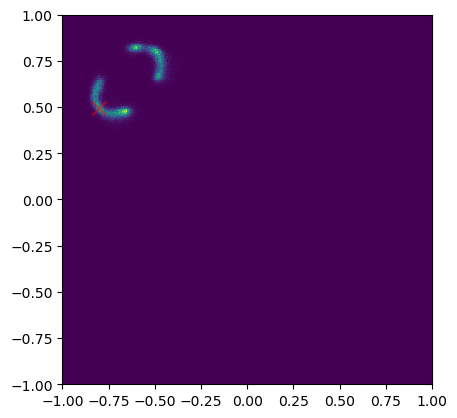

In [50]:
posterior_samples_cfg = samples_cfg

plt.hist2d(posterior_samples_cfg[:,0], posterior_samples_cfg[:,1], bins=(500,500), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

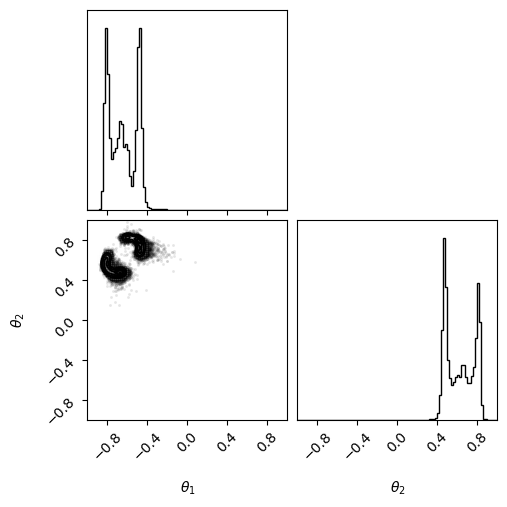

In [51]:
corner(np.array(posterior_samples_cfg), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# sample with sde 

In [79]:
from flow_matching.solver import ZeroEnds

In [88]:
ze = ZeroEnds(gvf_wrapped, mu0=jnp.zeros(2), sigma0=jnp.ones(2), alpha=0.2)

In [89]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1

model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

In [90]:
sampler = ze.get_sampler(**model_extras)

In [91]:
samples = sampler(jax.random.PRNGKey(0), 100_000)

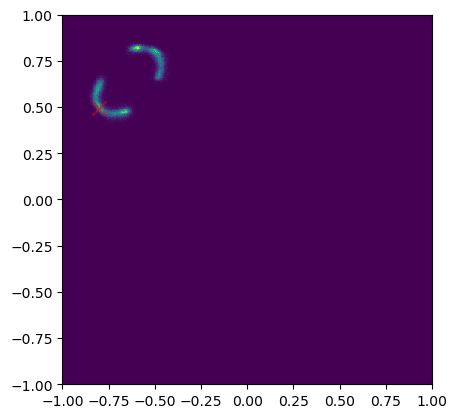

In [93]:
posterior_samples_sde = samples

plt.hist2d(posterior_samples_sde[:,0], posterior_samples_sde[:,1], bins=(500,500), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

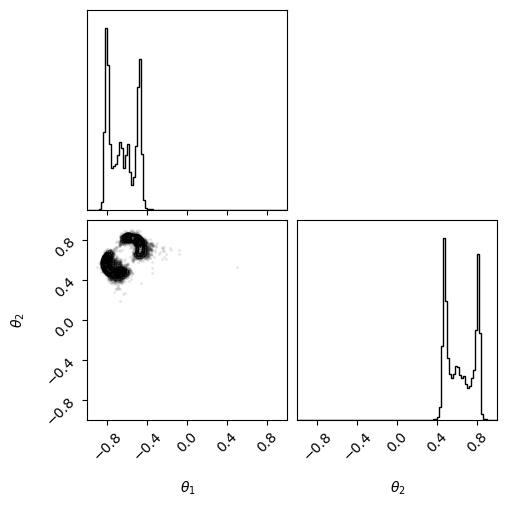

In [94]:
corner(np.array(posterior_samples_sde), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# C2ST test

In [52]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx = 8
observation = jnp.array(twomoons.get_observation(idx))
true_param = jnp.array(task.get_true_parameters(idx))
reference_samples = task.get_reference_posterior_samples(num_observation=idx)

# observation = data[0,:2].reshape((1,-1))
# true_param = data[0,2:].reshape((1,-1))
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = reference_samples.shape[0]

key1,key2 = jax.random.split(rng, 2)

x_init = jax.random.normal(key1,(nsamples, dim_x)) # n, T_max, 1
cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_theta, 1)) # n, dim_theta, 1

vf_wrapped = FluxWrapper(vf_model)
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}
res=vf_wrapped(x_init, jnp.array([1.0]), None, **model_extras)
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

sampler_ = solver.get_sampler(time_grid=T, method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model


In [96]:
# # convert posterior samples to a torch array
import torch
posterior_samples_torch = torch.tensor(np.array(posterior_samples_sde))
# posterior_samples_cfg_torch = torch.tensor(np.array(posterior_samples_cfg))

In [97]:

c2st_accuracy = c2st(reference_samples, posterior_samples_torch)
# c2st_accuracy_cfg = c2st(reference_samples, posterior_samples_cfg_torch)

In [99]:
c2st_accuracy#, c2st_accuracy_cfg

tensor([0.9089])

In [60]:
posterior_samples_rej, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=idx, num_simulations=100_000)

Running REJ-ABC
INFO:sbibm.algorithms.sbi.mcabc:Running REJ-ABC
Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 2192744.71it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382,

In [61]:

c2st(reference_samples, posterior_samples_rej)


tensor([0.6916])

In [68]:
c2st(posterior_samples_torch, posterior_samples_rej)

tensor([0.9169])